In [1]:
from matplotlib import pyplot as plt
import platform, os, sys, h5py
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\Gerwin\Documents\Code')
    from BEMHelper import interpolate_slow
else:
    sys.path.append('/mnt/s/_Data/160603 - EonHe M016v5/modules')
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    %config InlineBackend.figure_format='retina'

from Common import common, kfit
from TrapAnalysis import trap_analysis, import_data, artificial_anneal as anneal
from HeliumSurface.static_surface import *
from ipywidgets import interact

%matplotlib inline

## Setting up the model

In [2]:
from scipy.constants import elementary_charge as qe, electron_mass as me, epsilon_0 as eps0
from math import pi as pi

In this notebook I simulate the unloading of the trap using a simple model with four parameters. The main assumption in this model is that the trap is harmonic with similar trap frequencies in both directions (i.e. a radially symmetric trap). 

Generally, the trap guard changes both the barrier height, as well as the trap frequency. I take both of these changes into account. In particular, I assume that $\omega^2$ and $V_\mathrm{barrier}$ depend linearly on the trap guard voltage: 

$$V_\mathrm{barrier} = V_\mathrm{bar} + \beta V_\mathrm{tg}$$
$$\omega^2 = \omega_0^2 (1 + \alpha V_\mathrm{tg})$$

$\alpha, \beta \geq 0$. But note that $\beta=0$ makes no sense, since no matter how flat the trap if the barrier stays high there's no chance of electrons leaving the dot. $\alpha$ can be set to zero, and this could make sense if you only want to study the effect of lowering the barrier.

In a radially symmetric harmonic trap the electron positions can be calculated analytically. The energy cost to place a single electron in the trap is 0, since it will sit in the energy minimum and there is no interaction energy. The 2nd electron will force both electrons to be off-center and add some Coulomb repulsion. Adding a third electron will result in a triangular lattice with even higher Coulomb repulsion. 

The condition at which electrons leave the trap is when the barrier height is equal to the energy per particle of the system at the trap guard escape voltage. For any number of trapped electrons this means 

$$V_\mathrm{electrostatic} (V_\mathrm{tg}^{(n)}) + V_\mathrm{Coulomb} (V_\mathrm{tg}^{(n)}) = V_\mathrm{bar} + \beta V_\mathrm{tg}$$

where $V_\mathrm{tg}^{(n)}$ is the trap guard voltage at which unloading happens for $n$ electrons in the dot. Except for $n = 1$, this is a non-linear equation and is most easily solved numerically. For $n = 1$, the unloading voltage is given by $V_\mathrm{tg}^{(1)} = -V_\mathrm{bar}/\beta$. 

The goal of this notebook is to determine the trap guard voltage at which these jumps occur for $n = 1, 2, 3$ electrons in the trap.

Below we initialize the four parameters that determine the unloading behavior. For starters I can set $\alpha=0$ to just look at the effect of lowering the barrier

In [3]:
f0 = 10E9
omega0 = 2 * np.pi * f0 / np.sqrt(qe)
alpha = 0
Vbar = 0.010
beta = Vbar / 0.305

print(-Vbar/beta)
if alpha != 0:
    print(-1/alpha)

-0.305


In the cell above, I've renormalized $\omega_0$, such that I can specify $f_0$ in units of Hz. This rescaling comes from $E = \frac{1}{2} m \omega^2 x^2 V$, Since we're looking at voltages in the example above, I'd like to convert this into a voltage. This can be done by dividing by $e$, such that $$\frac{E}{e} = \frac{1}{2} m \left(\frac{\omega^2}{e}\right) x^2$$

In [14]:
def trap_frequency(Vtg, omega0, alpha):
    return np.sqrt(omega0**2 * (1 + alpha * Vtg))

def barrier_height(Vtg, Vbar, beta):
    return Vbar + beta * Vtg

def d2(Vtg, omega0, alpha):
    omega = trap_frequency(Vtg, omega0, alpha)
    return (qe / (pi * eps0 * me * omega ** 2)) ** (1/3.)

def d3(Vtg, omega0, alpha):
    omega = trap_frequency(Vtg, omega0, alpha)
    return (9 / 4. * qe / (4 * pi * eps0 * me * omega ** 2)) ** (1/3.)

def V2e_jump(Vtg, omega0, alpha, Vbar, beta):
    distance = d2(Vtg, omega0, alpha)
    omega = trap_frequency(Vtg, omega0, alpha)
    Vb = barrier_height(Vtg, Vbar, beta)
    return 1 / 2. * (1 / 8. * (me * omega ** 2 * distance ** 2) + qe / (4 * pi * eps0 * distance)) - Vb

def V3e_jump(Vtg, omega0, alpha, Vbar, beta):
    distance = d3(Vtg, omega0, alpha)
    omega = trap_frequency(Vtg, omega0, alpha)
    Vb = barrier_height(Vtg, Vbar, beta)
    return 1 / 3. * (1 / 6. * (me * omega ** 2 * distance ** 2) + 3 * qe / (4 * pi * eps0 * distance)) - Vb

Let's take a look at the parameters we've chosen.

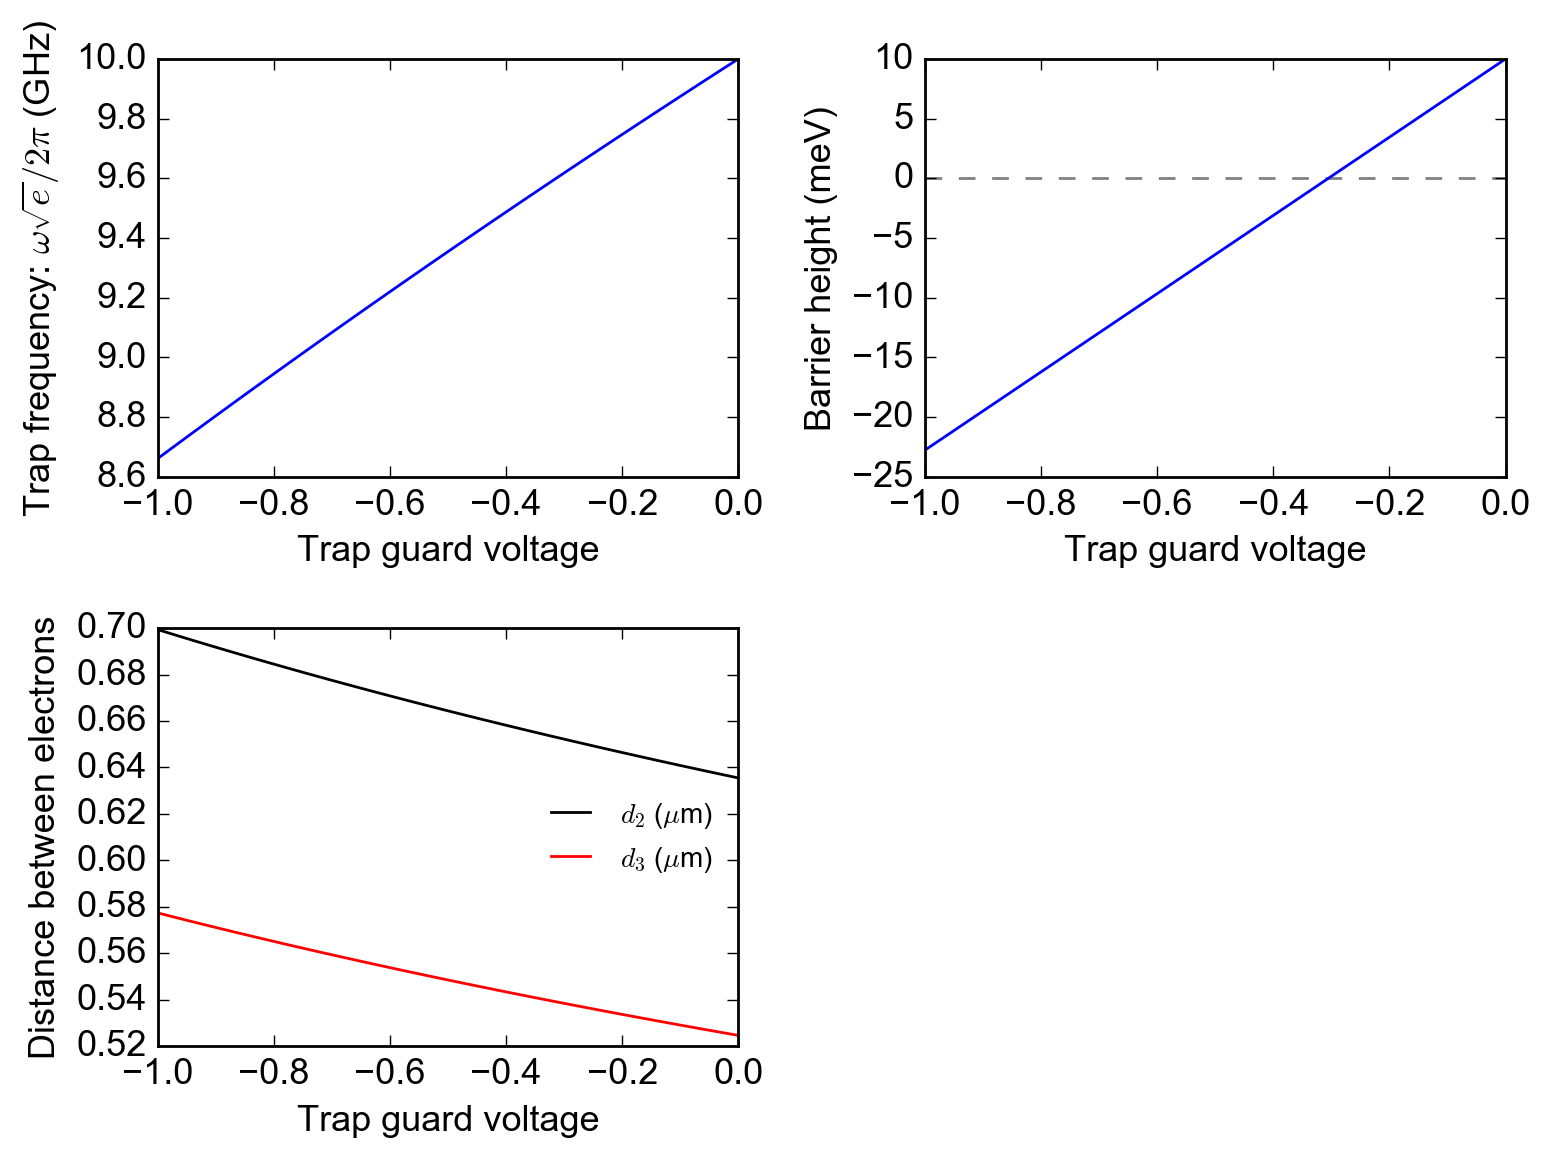

In [15]:
Vtg = np.linspace(-1.0, 0.0, 101)

fig = plt.figure(figsize=(8., 6.))
common.configure_axes(13)
plt.subplot(221)
plt.plot(Vtg, trap_frequency(Vtg, omega0, alpha) * np.sqrt(qe) / (2*np.pi * 1E9))
plt.xlabel("Trap guard voltage")
plt.ylabel("Trap frequency: $\omega \sqrt{e}/2\pi$ (GHz)")

plt.subplot(222)
plt.plot(Vtg, barrier_height(Vtg, Vbar, beta) * 1E3)
plt.hlines(0.00, np.min(Vtg), np.max(Vtg), linestyles="--", color='gray')
plt.ylabel("Barrier height (meV)")
plt.xlabel("Trap guard voltage")

plt.subplot(223)
plt.plot(Vtg, d2(Vtg, omega0, alpha) * 1E6, '-k', label="$d_2$ ($\mu$m)")
plt.ylabel("Distance between electrons")

plt.plot(Vtg, d3(Vtg, omega0, alpha) * 1E6, '-r', label="$d_3$ ($\mu$m)")
plt.xlabel("Trap guard voltage")
plt.legend(loc=0, frameon=False, prop={"size" : 10})

fig.tight_layout()

To solve for the trap voltage at which the unloading occurs for each number of electrons, we use `scipy.optimize.newton`. This is a simple rootfinding algorithm and requires only an initial condition as input parameter. Note that if you choose the initial guess such that the trap can't hold *any* electrons (this can happen if the curvature is positive for example) the algorithm tends not to work well. 

In [16]:
from scipy.optimize import newton

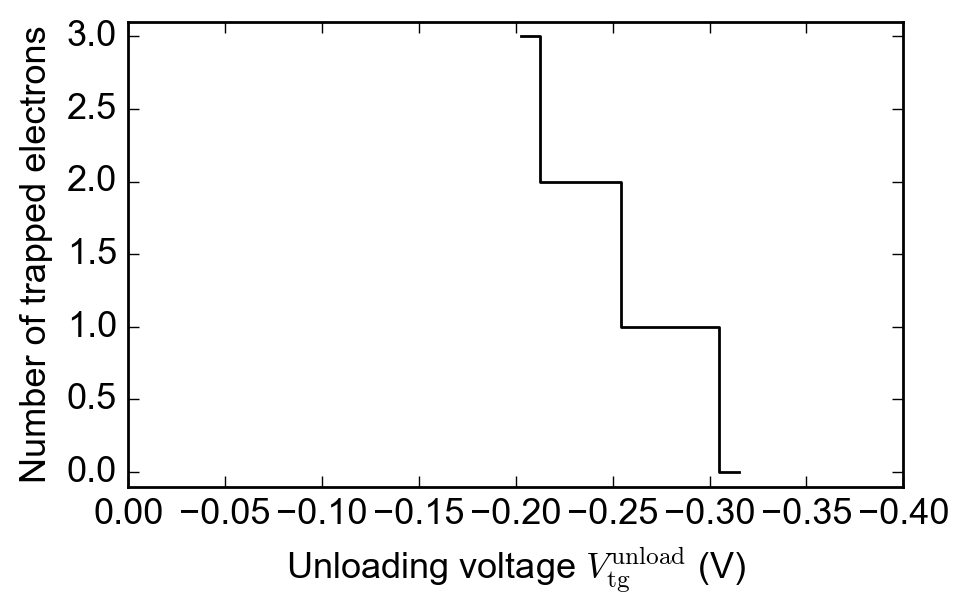

In [17]:
if alpha != 0:
    init_guess = 1/alpha + 0.1
else:
    init_guess = -0.1
    
plt.figure(figsize=(5.,3.))
common.configure_axes(13)
plt.step([-Vbar/beta-0.01, -Vbar/beta, 
          newton(func=V2e_jump, x0=init_guess, args=(omega0, alpha, Vbar, beta)), 
          newton(func=V3e_jump, x0=init_guess, args=(omega0, alpha, Vbar, beta)), 
          newton(func=V3e_jump, x0=init_guess, args=(omega0, alpha, Vbar, beta))+0.01], 
         [0, 0, 1, 2, 3], 'k')
plt.ylim(-0.1, 3.1)
plt.xlim(0, -0.4)
plt.ylabel("Number of trapped electrons")
plt.xlabel("Unloading voltage $V_\mathrm{tg}^\mathrm{unload}$ (V)")

## Images for presentation

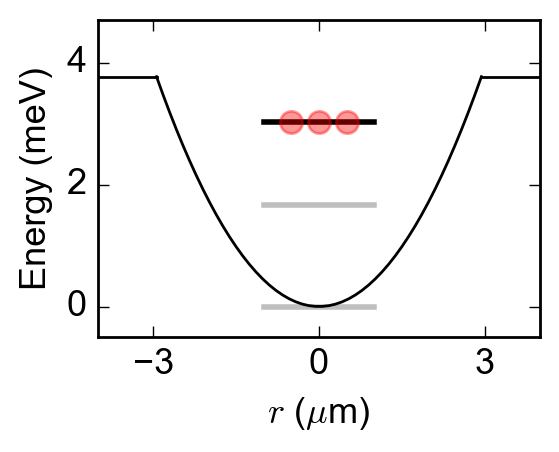

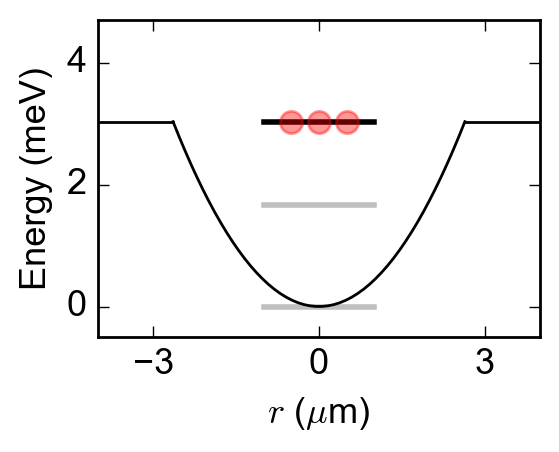

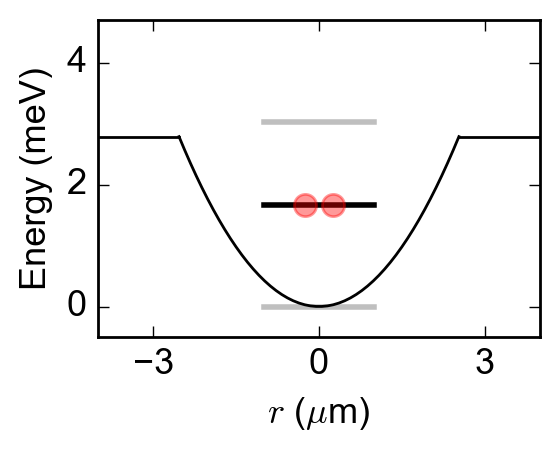

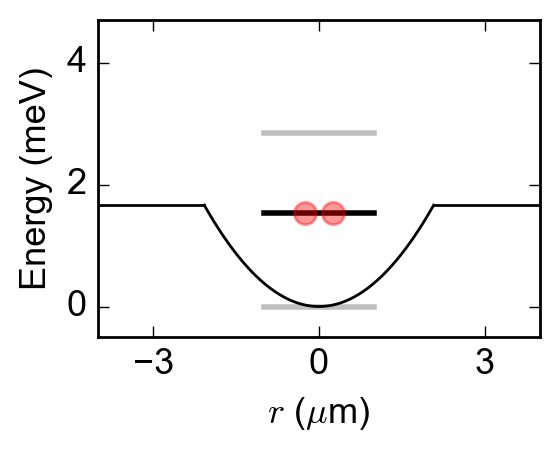

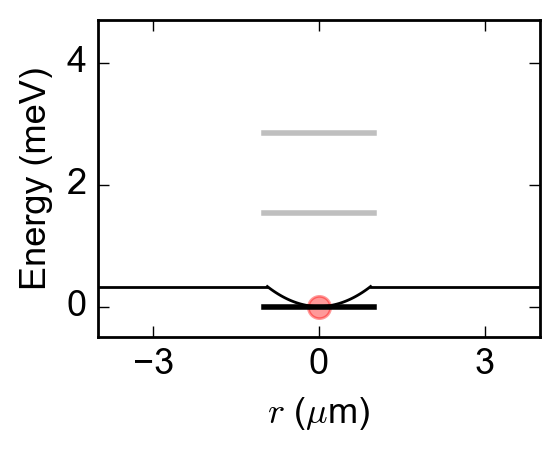

In [18]:
ns = [3, 3, 2, 2, 1]
kk = 0
for n, Vtg in zip(ns, [-0.19, 
            newton(func=V3e_jump, x0=init_guess, args=(omega0, alpha, Vbar, beta)), 
            -0.22, 
            newton(func=V2e_jump, x0=init_guess, args=(omega0, alpha, Vbar, beta)), 
            -Vbar/beta + 0.01]):
    
    kk += 1
    startx = -np.sqrt(barrier_height(Vtg, Vbar, beta)*2*qe/(me*trap_frequency(Vtg, omega0, alpha)))
    stopx = np.sqrt(barrier_height(Vtg, Vbar, beta)*2*qe/(me*trap_frequency(Vtg, omega0, alpha)))
    xplot = np.linspace(startx, stopx)
    
    Epot_eV = 1/2. * me * trap_frequency(Vtg, omega0, alpha) * xplot**2 / qe

    fig = plt.figure(figsize=(3.,2.5)) 
    common.configure_axes(13)
    plt.plot(xplot * 1E6, Epot_eV * 1E3, 'k')
    plt.plot(np.linspace(np.max(xplot), 4E-6)*1E6, 
             barrier_height(Vtg, Vbar, beta) * np.ones(50) * 1E3, 'k')
    plt.plot(np.linspace(-4E-6, np.min(xplot))*1E6, 
             barrier_height(Vtg, Vbar, beta) * np.ones(50) * 1E3, 'k')
    
    plt.fill_between(xplot * 1E6, barrier_height(Vtg, Vbar, beta) * 1E3, y2=Epot_eV[0] * 1E3, 
                     color='navy', lw=0)
    
    for N, levels in zip([3, 2], [newton(func=V3e_jump, x0=init_guess, args=(omega0, alpha, Vbar, beta)), 
                                  newton(func=V2e_jump, x0=init_guess, args=(omega0, alpha, Vbar, beta))]):
        
        x0, x1 = -1, 1
        y0 = barrier_height(levels, Vbar, beta) * 1E3
        alpha = 1.0 if N == n else 0.25
        plt.plot([x0, x1], [y0, y0], '-', lw=2, color='k', alpha=alpha)
        
        spacing = 0.5
        if N == n == 3:
            plt.plot([-spacing, 0, spacing], [y0] * 3, 'o', **common.plot_opt('red'))
        elif N == n == 2:
            plt.plot([-spacing/2., spacing/2.], [y0] * 2, 'o', **common.plot_opt('red'))
    
    if n == 1: 
        plt.plot([0], [0], 'o', **common.plot_opt('red'))
        plt.plot([x0, x1], [0, 0], '-', lw=2, color='k', alpha=1.0)
    else:
        plt.plot([x0, x1], [0, 0], '-', lw=2, color='k', alpha=0.25)
    
    plt.xlabel("$r$ ($\mu$m)")
    plt.ylabel("Energy (meV)")
    
    plt.ylim(-0.5, 4.7)
    
    plt.yticks([0, 2, 4])
    plt.xticks([-3, 0, 3])
    
    fig.tight_layout()
    
    sp = r"/Users/gkoolstra/Google Drive/grad school/schuster lab/Presentations/March Meeting 2018"
#     fig.savefig(os.path.join(sp, "unloading_%02d.pdf" % kk))